### Import section

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from skimage import color
from skimage.feature import hog

In [2]:
import warnings
import itertools
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# !pip install visualkeras
import tensorflow as tf
import visualkeras
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# pip install opencv-python
import cv2
import os

folder_path = "ds_two"             # base/root directory

no_tumor = os.listdir(folder_path + '/no_tumor/')
glioma = os.listdir(folder_path + '/glioma/')
meningioma = os.listdir(folder_path + '/meningioma/')
pituitary = os.listdir(folder_path + '/pituitary/')
craniopharyngioma = os.listdir(folder_path + '/craniopharyngioma_final_1070/')

# no_tumor, glioma, meningioma, pituitary, craniopharyngioma

dataset=[]
lab=[]

In [5]:
for image_name in no_tumor:
    image=cv2.imread(folder_path + '/no_tumor/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)

In [6]:
for image_name in glioma:
    image=cv2.imread(folder_path + '/glioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [7]:
for image_name in meningioma:
    image=cv2.imread(folder_path + '/meningioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(2)

In [8]:
for image_name in pituitary:
    image=cv2.imread(folder_path + '/pituitary/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(3)

In [9]:
for image_name in craniopharyngioma:
    image=cv2.imread(folder_path + '/craniopharyngioma_final_1070/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(4)

In [10]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(8103, 240, 240, 3) (8103,)


### Load the Extracted Deep Features

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255)

subdirectories = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma_final_1070']

# Create a generator for the images in the subdirectories
generator = datagen.flow_from_directory(
    folder_path,
    target_size=(240,240),
    batch_size=32,
    class_mode='categorical',
#     class_mode=None,
    shuffle=False,
    classes=subdirectories)

Found 8103 images belonging to 5 classes.


In [12]:
# Input layer
from keras.layers import Concatenate, Input, Flatten, Dense

input_layer = Input(shape=(240, 240, 3))

# Load extracted concatenated_features
concatenated_features = np.load('efe_features.npy')

In [13]:
print(len(concatenated_features))

8103


In [14]:
print(len(concatenated_features[1]))

149381


In [15]:
from tensorflow.keras.layers import Input

# Flatten the features to use them for classification
features_flatten = np.reshape(concatenated_features, (concatenated_features.shape[0], -1))

# Define the labels for the images in the subdirectories
labels = generator.classes

### XGBoost

In [16]:
from xgboost import XGBClassifier

# Rest of the code
train_features, test_features, train_labels, test_labels = train_test_split(
    features_flatten, labels, test_size=0.2, random_state=42)

xgbc = XGBClassifier()
print(xgbc)

xgbc.fit(train_features, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [17]:
# Predict the labels of the testing set using the trained XGBC model
predicted_labels = xgbc.predict(test_features)

# Generate a classification report and confusion matrix
report = classification_report(test_labels, predicted_labels, target_names=subdirectories)
matrix = confusion_matrix(test_labels, predicted_labels)

print(report)

                              precision    recall  f1-score   support

                    no_tumor       0.99      0.98      0.98       414
                      glioma       0.99      0.92      0.96       335
                  meningioma       0.90      0.93      0.92       339
                   pituitary       0.93      0.98      0.96       345
craniopharyngioma_final_1070       0.99      0.97      0.98       188

                    accuracy                           0.96      1621
                   macro avg       0.96      0.96      0.96      1621
                weighted avg       0.96      0.96      0.96      1621



In [18]:
print(matrix)

[[405   0   6   2   1]
 [  0 309  24   2   0]
 [  2   2 316  19   0]
 [  1   1   4 339   0]
 [  3   0   1   1 183]]


In [19]:
from sklearn.metrics import r2_score
r2_score(test_labels, predicted_labels)

0.9363095817211624

In [20]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(test_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'],

                     columns = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'])

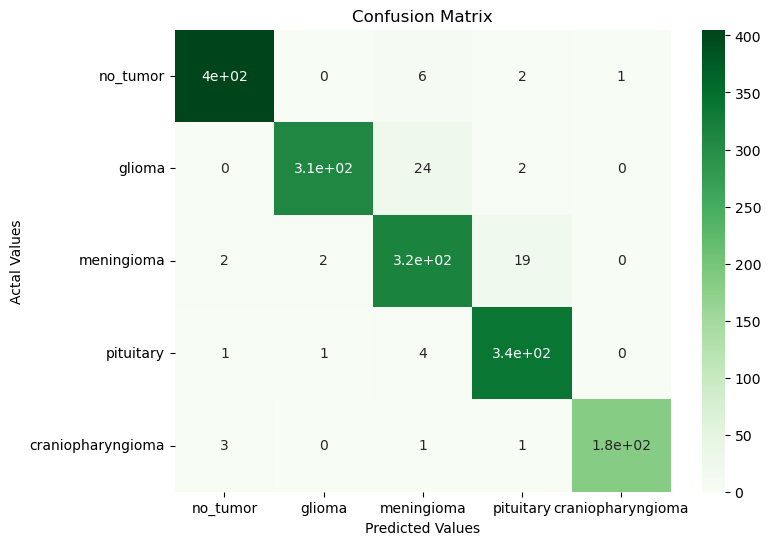

In [21]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

#### All Performance Scores

In [22]:
from sklearn.metrics import precision_score
precision_score(test_labels, predicted_labels,average='micro')

0.9574336829117829

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)

0.9574336829117829

In [24]:
from sklearn.metrics import f1_score
f1_score(test_labels, predicted_labels,average='micro')

0.9574336829117829

In [25]:
from sklearn.metrics import recall_score
recall_score(test_labels, predicted_labels,average='micro')

0.9574336829117829

In [26]:
test_labels.shape

(1621,)

#### AUC Curve

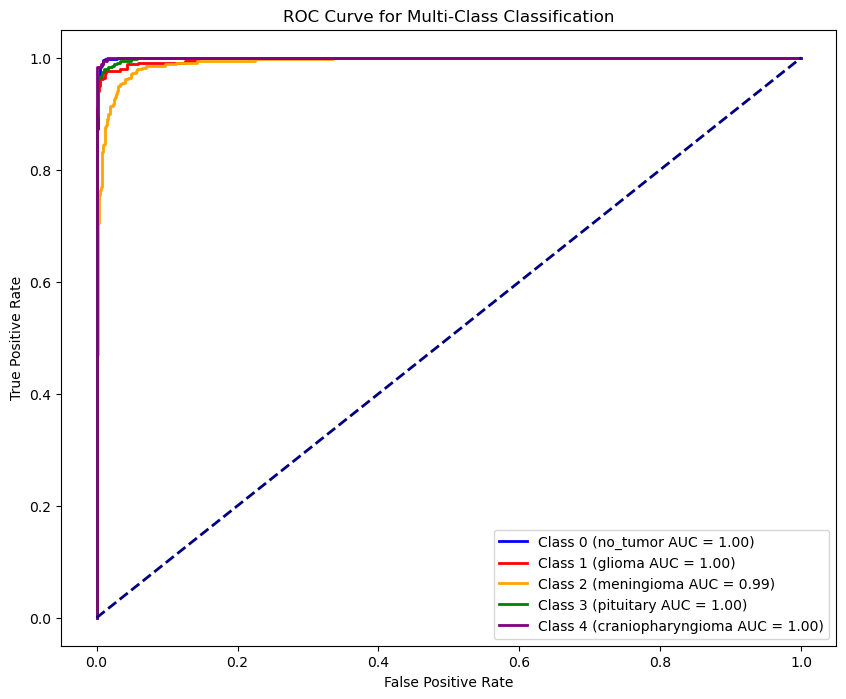

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

classes = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma']

y_true = test_labels

y_prob = xgbc.predict_proba(test_features)

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(5))

# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()

#### Precision-Recall Curve

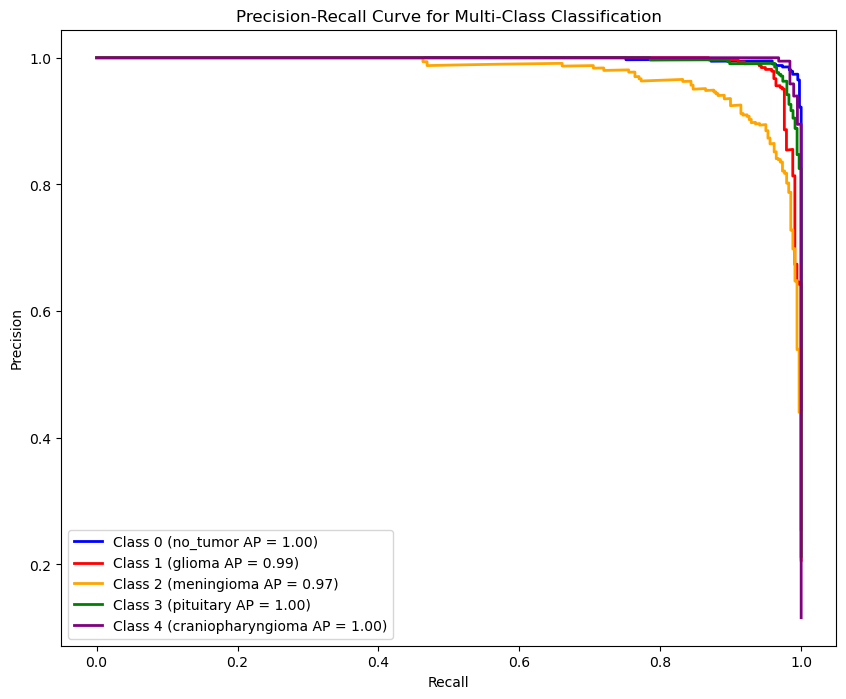

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize arrays for precision-recall curve
precision = dict()
recall = dict()
average_precision = dict()


for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the precision-recall curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend()
plt.show()

[[405   0   6   2   1]
 [  0 309  24   2   0]
 [  2   2 316  19   0]
 [  1   1   4 339   0]
 [  3   0   1   1 183]]


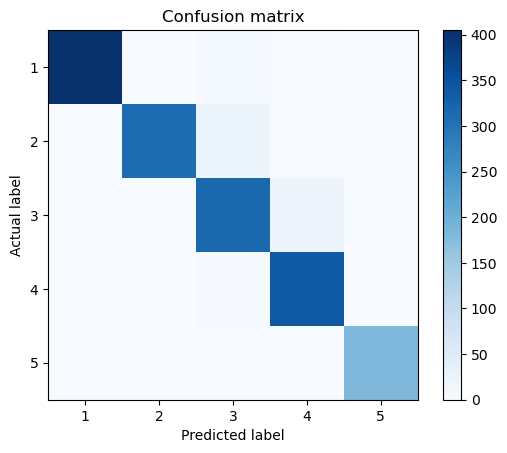

In [29]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Find the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Print the confusion matrix
print(cm)

# Plot the confusion matrix as a heatmap
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(5), np.arange(1, 6))
plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion matrix')
plt.show()

#### Specificity, TPR, TNR, FPR, FNR

In [30]:
# Import numpy library
import numpy as np

cm = matrix

# Get the number of classes
n_classes = cm.shape[0]

# Initialize an empty list to store the specificity values
specificity = []

# Loop over each class
for i in range(n_classes):
  # Calculate the true negatives and false positives for class i
  tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i])
  fp = np.sum(cm[:, i]) - cm[i, i]

  # Calculate the specificity for class i
  spec = tn / (tn + fp)

  # Append the specificity to the list
  specificity.append(spec)

# Print the specificity values
print("Specificity for each class:")
for i in range(n_classes):
  print(f"Class {i}: {specificity[i]:.2f}")

Specificity for each class:
Class 0: 0.99
Class 1: 1.00
Class 2: 0.96
Class 3: 0.97
Class 4: 1.00


In [31]:
# Import numpy library
import numpy as np

# Calculate the false positives, false negatives, true positives, and true negatives for each class
fp = np.sum(cm, axis=0) - np.diag(cm)
fn = np.sum(cm, axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = np.sum(cm) - (fp + fn + tp)

# Calculate the false positive rate, false negative rate, true positive rate, and true negative rate for each class
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

# Print the FPR, FNR, TPR, and TNR values for each class
print("FPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fpr[i]:.2f}")

print("FNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fnr[i]:.2f}")

print("TPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tpr[i]:.2f}")

print("TNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tnr[i]:.2f}")

FPR for each class:
Class 0: 0.00
Class 1: 0.00
Class 2: 0.03
Class 3: 0.02
Class 4: 0.00
FNR for each class:
Class 0: 0.02
Class 1: 0.08
Class 2: 0.07
Class 3: 0.02
Class 4: 0.03
TPR for each class:
Class 0: 0.98
Class 1: 0.92
Class 2: 0.93
Class 3: 0.98
Class 4: 0.97
TNR for each class:
Class 0: 1.00
Class 1: 1.00
Class 2: 0.97
Class 3: 0.98
Class 4: 1.00


### Cross Validation Section

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# K-Fold parameters
n_splits = 10

# KFold object
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store results
all_y_true = []
all_y_pred = []
confusion_matrices = []

fold_accuracies = []
precisions = []
recalls = []
f1_scores = []

precision_recall_data = []

y_true_bin_cv_all = [] # all binarized true labels
y_proba_all = [] # to store all the proba scores

i = 0


for train_index, val_index in kfold.split(features_flatten):
    # Select training and validation data for current fold
    x_train_fold, x_val_fold = (
        features_flatten[train_index],
        features_flatten[val_index],
    )
    y_train_fold, y_val_fold = labels[train_index], labels[val_index]

    # Create and train the XGB model
    xgbc.fit(x_train_fold, y_train_fold)

    # Evaluate the model on the validation fold
    y_pred_fold = xgbc.predict(x_val_fold)
    fold_accuracy = accuracy_score(y_val_fold, y_pred_fold)
    # precision, recall, _ = precision_recall_curve(y_val_fold, y_pred_fold)
    (precision, recall, f1_score, _) = precision_recall_fscore_support(
        y_val_fold, y_pred_fold, average="weighted", zero_division=0
    )

    # Predict probabilities for the test set
    y_probs = xgbc.predict_proba(x_val_fold)
    y_proba_all.append(y_probs)

    print("-------------------------------------------------------------")
    # Print accuracy for this fold
    print(f"Fold {i+1}:")
    print(f"Accuracy: {fold_accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")
    print("-------------------------------------------------------------")

    print("\n\n\n-------------------------------------------------------------")
    print("\nClassification Report for this fold:")
    report = classification_report(y_val_fold, y_pred_fold)
    print(report)
    print("\n\n-------------------------------------------------------------")

    # Calculate confusion matrix for this fold
    confusion_matrix_per_fold = confusion_matrix(y_val_fold, y_pred_fold)
    confusion_matrices.append(confusion_matrix_per_fold)

    # Calculate and store precision-recall for this fold
    fold_accuracies.append(fold_accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    i += 1

    # Store true labels and predicted labels for report and plots
    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_pred_fold)

    # Binarize the true labels
    y_true_bin_cv = label_binarize(y_val_fold, classes=np.arange(5))
    y_pred_bin_cv = label_binarize(y_pred_fold, classes=np.arange(5))

    precision_dict = dict()
    recall_dict = dict()
    average_precision = dict()

    for j in range(0, n_classes):
        precision_dict[j], recall_dict[j], _ = precision_recall_curve(y_val_fold == j, y_probs[:, j])
        average_precision[j] = average_precision_score(y_val_fold == j, y_probs[:, j])

#         average_precisions.append(average_precision)
    precision_recall_data.append((precision_dict, recall_dict, average_precision))

    # Binarize the true labels
    y_true_bin_cv = label_binarize(y_val_fold, classes=np.arange(5))
    y_true_bin_cv_all.append(y_true_bin_cv)

-------------------------------------------------------------
Fold 1:
Accuracy: 0.9642416769420469
Precision: 0.965435467610365
Recall: 0.9642416769420469
F1 Score: 0.9644415236674834
-------------------------------------------------------------



-------------------------------------------------------------

Classification Report for this fold:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       218
           1       0.99      0.93      0.96       153
           2       0.91      0.95      0.93       166
           3       0.94      0.99      0.96       174
           4       0.99      0.98      0.98       100

    accuracy                           0.96       811
   macro avg       0.97      0.96      0.96       811
weighted avg       0.97      0.96      0.96       811



-------------------------------------------------------------
-------------------------------------------------------------
Fold 2:
Accuracy: 0.9506781750924784

#### Precision-recall curves as subplots for each fold

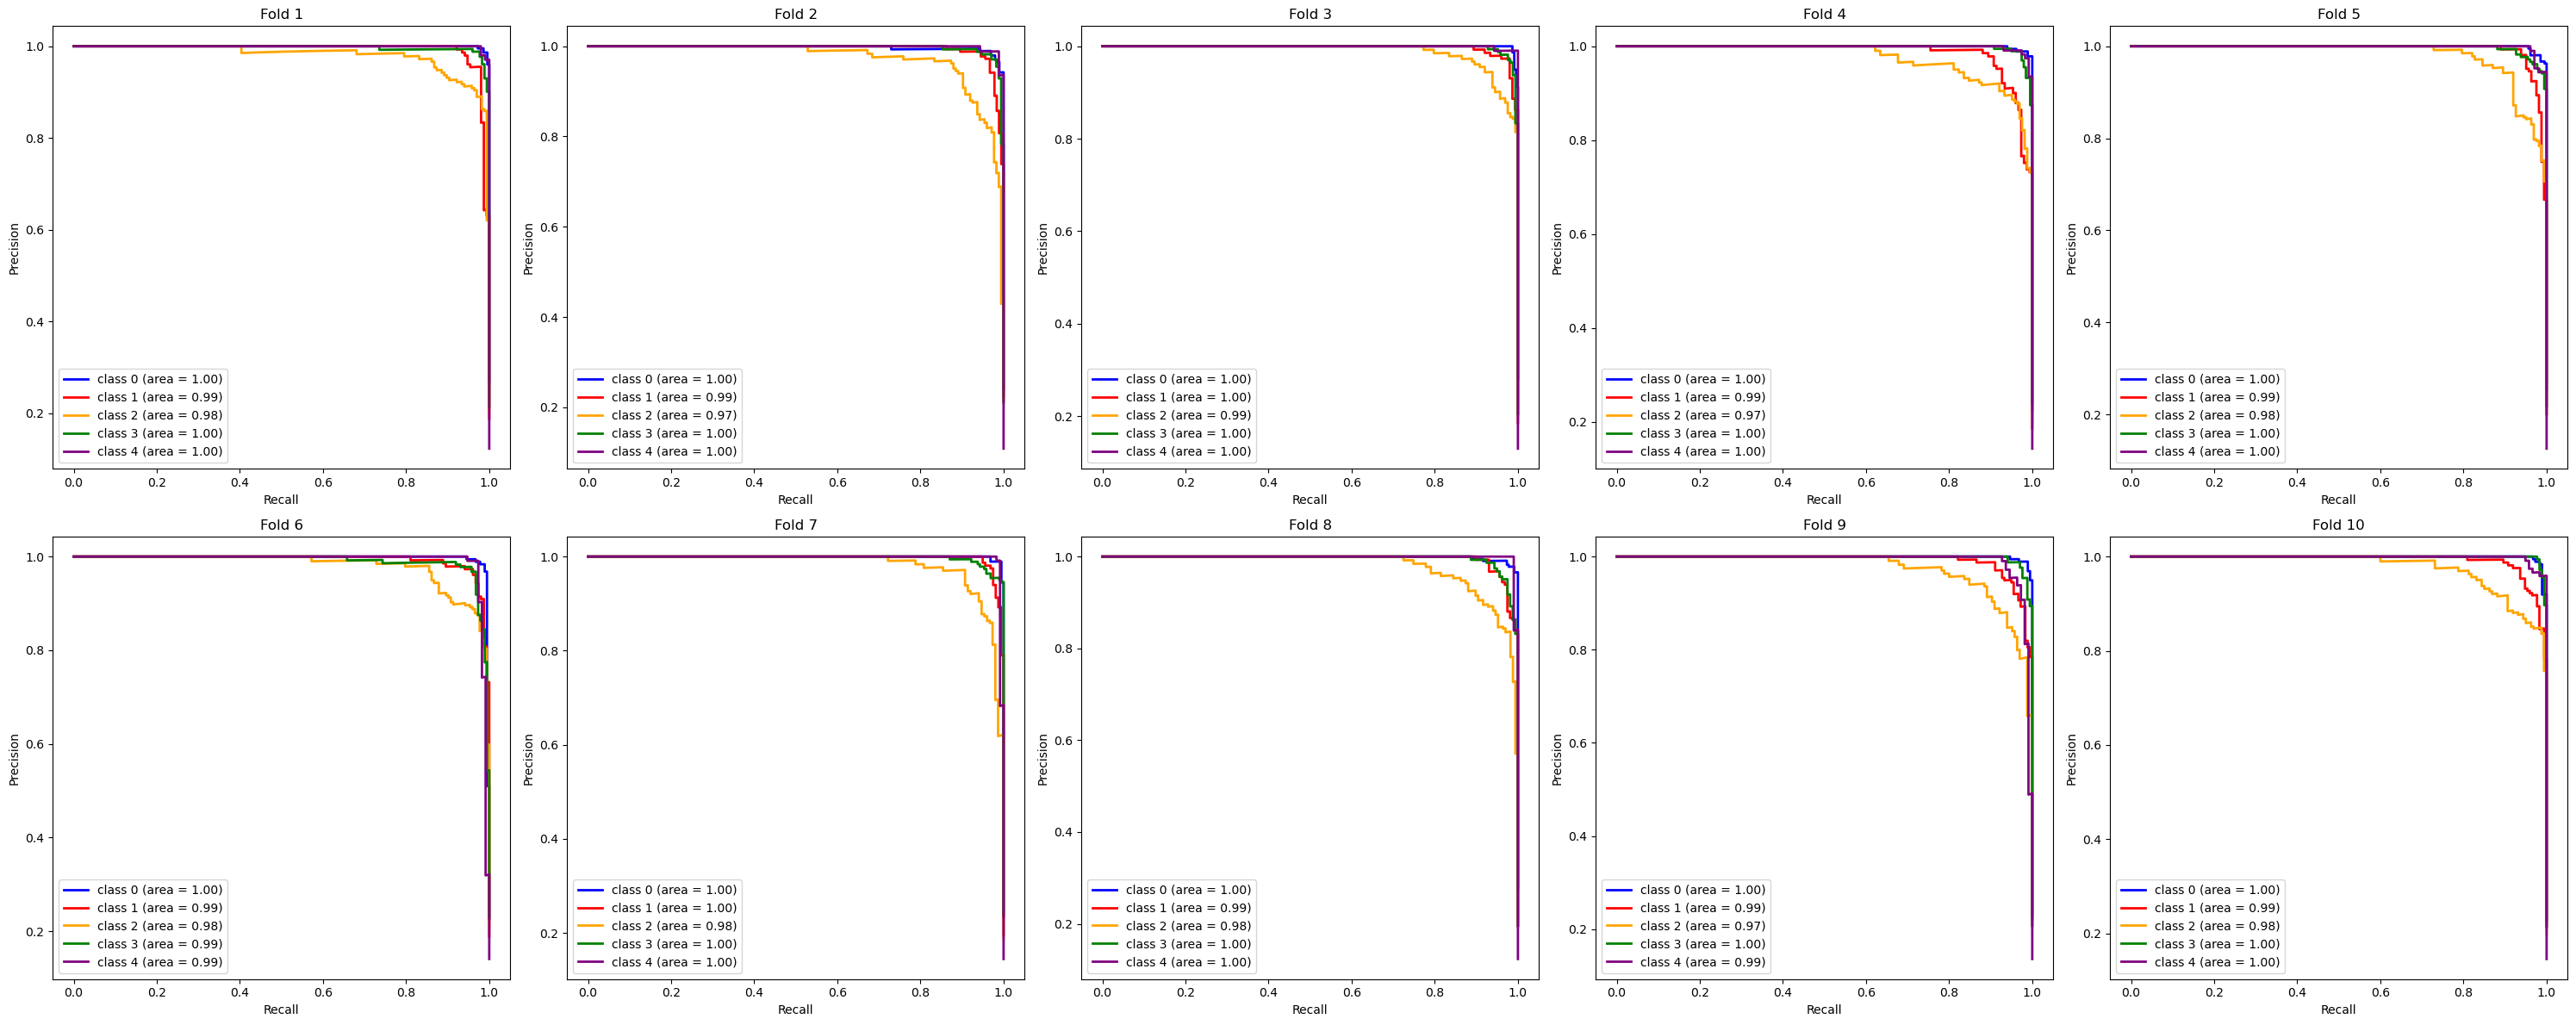

In [33]:
# Precision-recall curves as subplots for each fold

fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()

for i, (precision, recall, average_precision) in enumerate(precision_recall_data):
    for j, color in zip(range(5), colors):
        axes[i].plot(recall[j], precision[j], color=color, lw=2,
                     label=f'class {j} (area = {average_precision[j]:0.2f})')
    axes[i].set_title(f'Fold {i+1}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()

#### Average Performance across folds

In [34]:
# Print average accuracy across folds
print('-------------------------------------------------------------')
print(f"Average Accuracy: {np.mean(fold_accuracies)}")
print(f"Average Precision: {np.mean(precisions)}")
print(f"Average Recall: {np.mean(recalls)}")
print(f"Average F1 Score: {np.mean(f1_scores)}")
print('-------------------------------------------------------------')

-------------------------------------------------------------
Average Accuracy: 0.956434975871885
Average Precision: 0.9576400621961177
Average Recall: 0.956434975871885
Average F1 Score: 0.95653770745669
-------------------------------------------------------------


#### Average Precision-Recall Curve

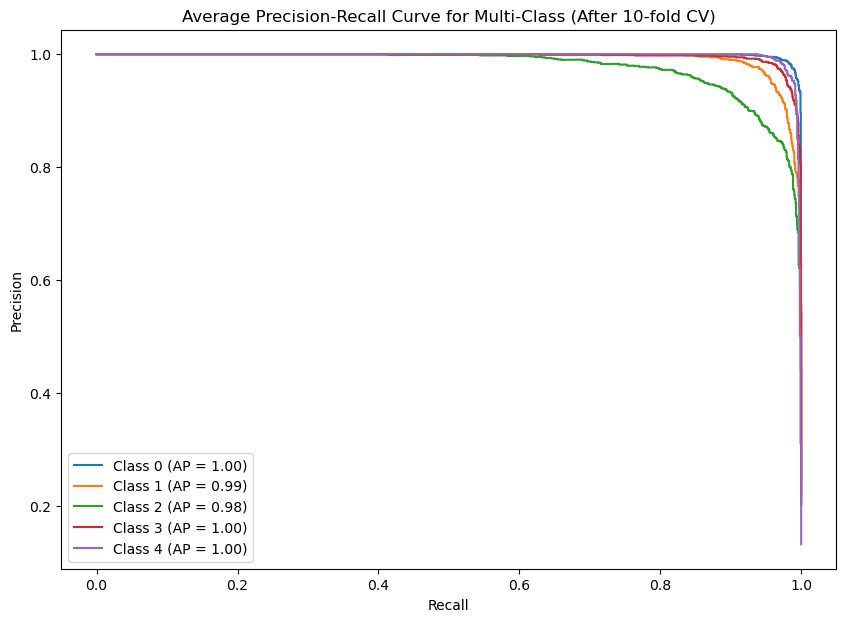

In [35]:
num_classes = 5

# Concatenate all fold results
y_proba_concat = np.concatenate(y_proba_all)
y_true_bin_concat = np.concatenate(y_true_bin_cv_all)

# Initialize dictionaries to store precision-recall data for all classes
all_precisions = {i: [] for i in range(num_classes)}
all_recalls = {i: [] for i in range(num_classes)}
all_average_precisions = {i: [] for i in range(num_classes)}

# Compute precision-recall curve and average precision for each class
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin_concat[:, i], y_proba_concat[:, i])
    average_precision = average_precision_score(y_true_bin_concat[:, i], y_proba_concat[:, i])

    # Store precision-recall data for each class
    all_precisions[i].append(precision)
    all_recalls[i].append(recall)
    all_average_precisions[i].append(average_precision)

# Calculate mean precision, recall, and average precision for each class
mean_precisions = {i: np.mean(all_precisions[i], axis=0) for i in range(num_classes)}
mean_recalls = {i: np.mean(all_recalls[i], axis=0) for i in range(num_classes)}
mean_average_precisions = {i: np.mean(all_average_precisions[i]) for i in range(num_classes)}

# Plot average precision-recall curve for each class
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(mean_recalls[i], mean_precisions[i], label=f'Class {i} (AP = {mean_average_precisions[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Average Precision-Recall Curve for Multi-Class (After 10-fold CV)')
plt.legend()
plt.grid(False)
plt.show()

#### Classification Report (After all folds)

In [36]:
# Classification report with average accuracy

print('-------------------------------------------------------------')
print("\nClassification Report:")
report = classification_report(all_y_true, all_y_pred)
print(report)

-------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2000
           1       0.98      0.92      0.95      1621
           2       0.90      0.93      0.91      1645
           3       0.94      0.98      0.96      1767
           4       1.00      0.96      0.97      1070

    accuracy                           0.96      8103
   macro avg       0.96      0.95      0.96      8103
weighted avg       0.96      0.96      0.96      8103



In [37]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(all_y_true, all_y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'],

                     columns = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'])

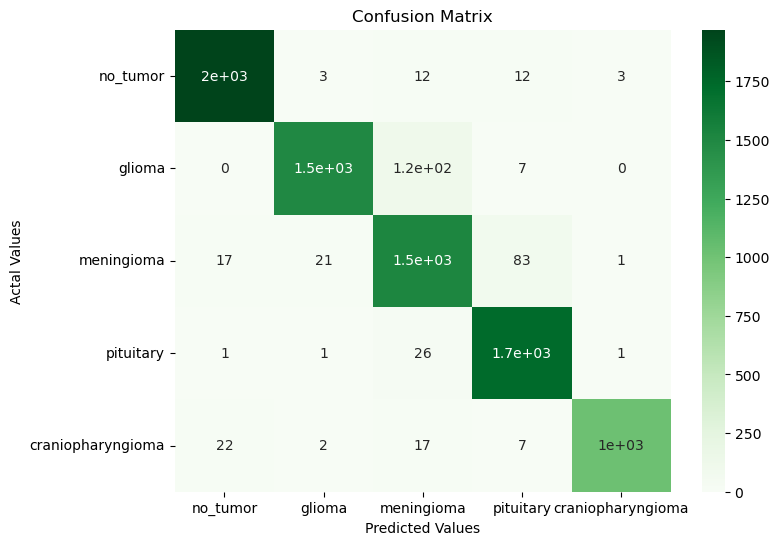

In [38]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

#### Resulting Plots

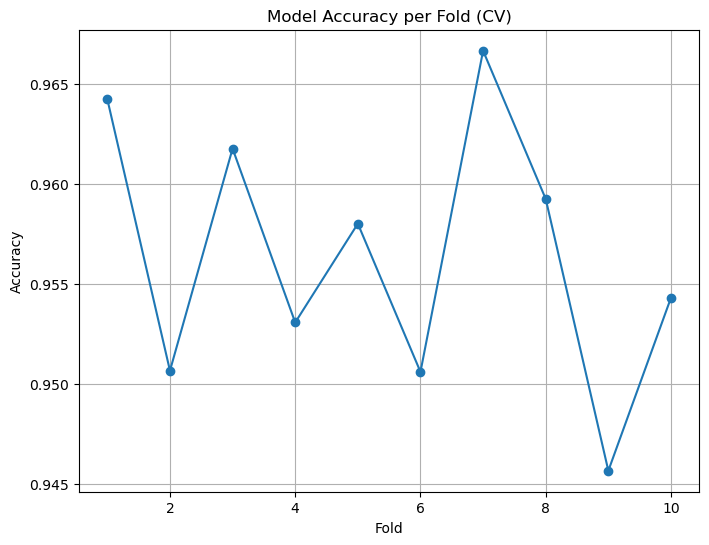

In [39]:
# Line Plot (Fold vs. Accuracy)

plt.figure(figsize=(8, 6))
plt.plot(range(1, n_splits + 1), fold_accuracies, marker='o', linestyle='-')
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Model Accuracy per Fold (CV)")
plt.grid(True)
plt.show()

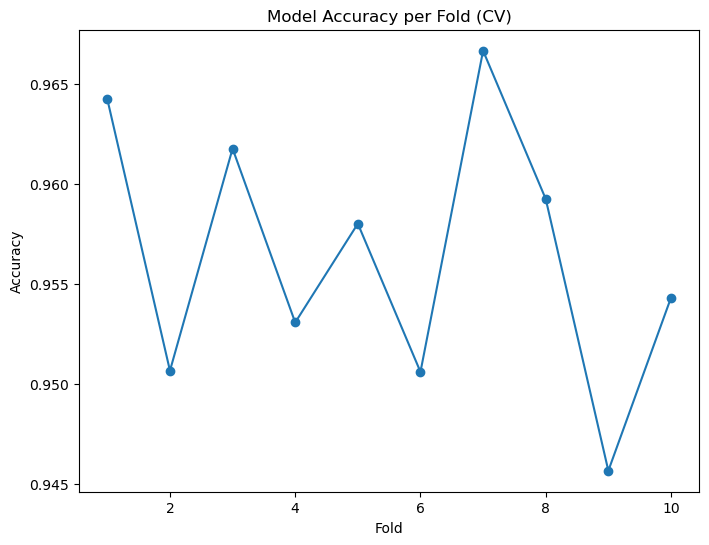

In [40]:
# Line Plot (Fold vs. Accuracy)

plt.figure(figsize=(8, 6))
plt.plot(range(1, n_splits + 1), fold_accuracies, marker='o', linestyle='-')
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Model Accuracy per Fold (CV)")
plt.grid(False)
plt.show()

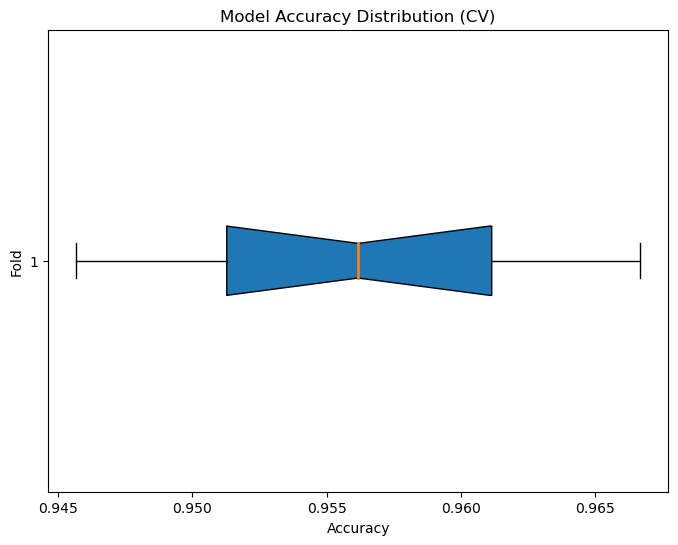

In [41]:
# Plot accuracy vs fold using fold_accuracies: box-plot

plt.figure(figsize=(8, 6))
plt.boxplot(fold_accuracies, vert=False, patch_artist=True, notch=True, medianprops={"linewidth": 2})
plt.xlabel("Accuracy")
plt.ylabel("Fold")
plt.title("Model Accuracy Distribution (CV)")
plt.grid(False)
plt.show()

#### Confusion Matrix for each fold

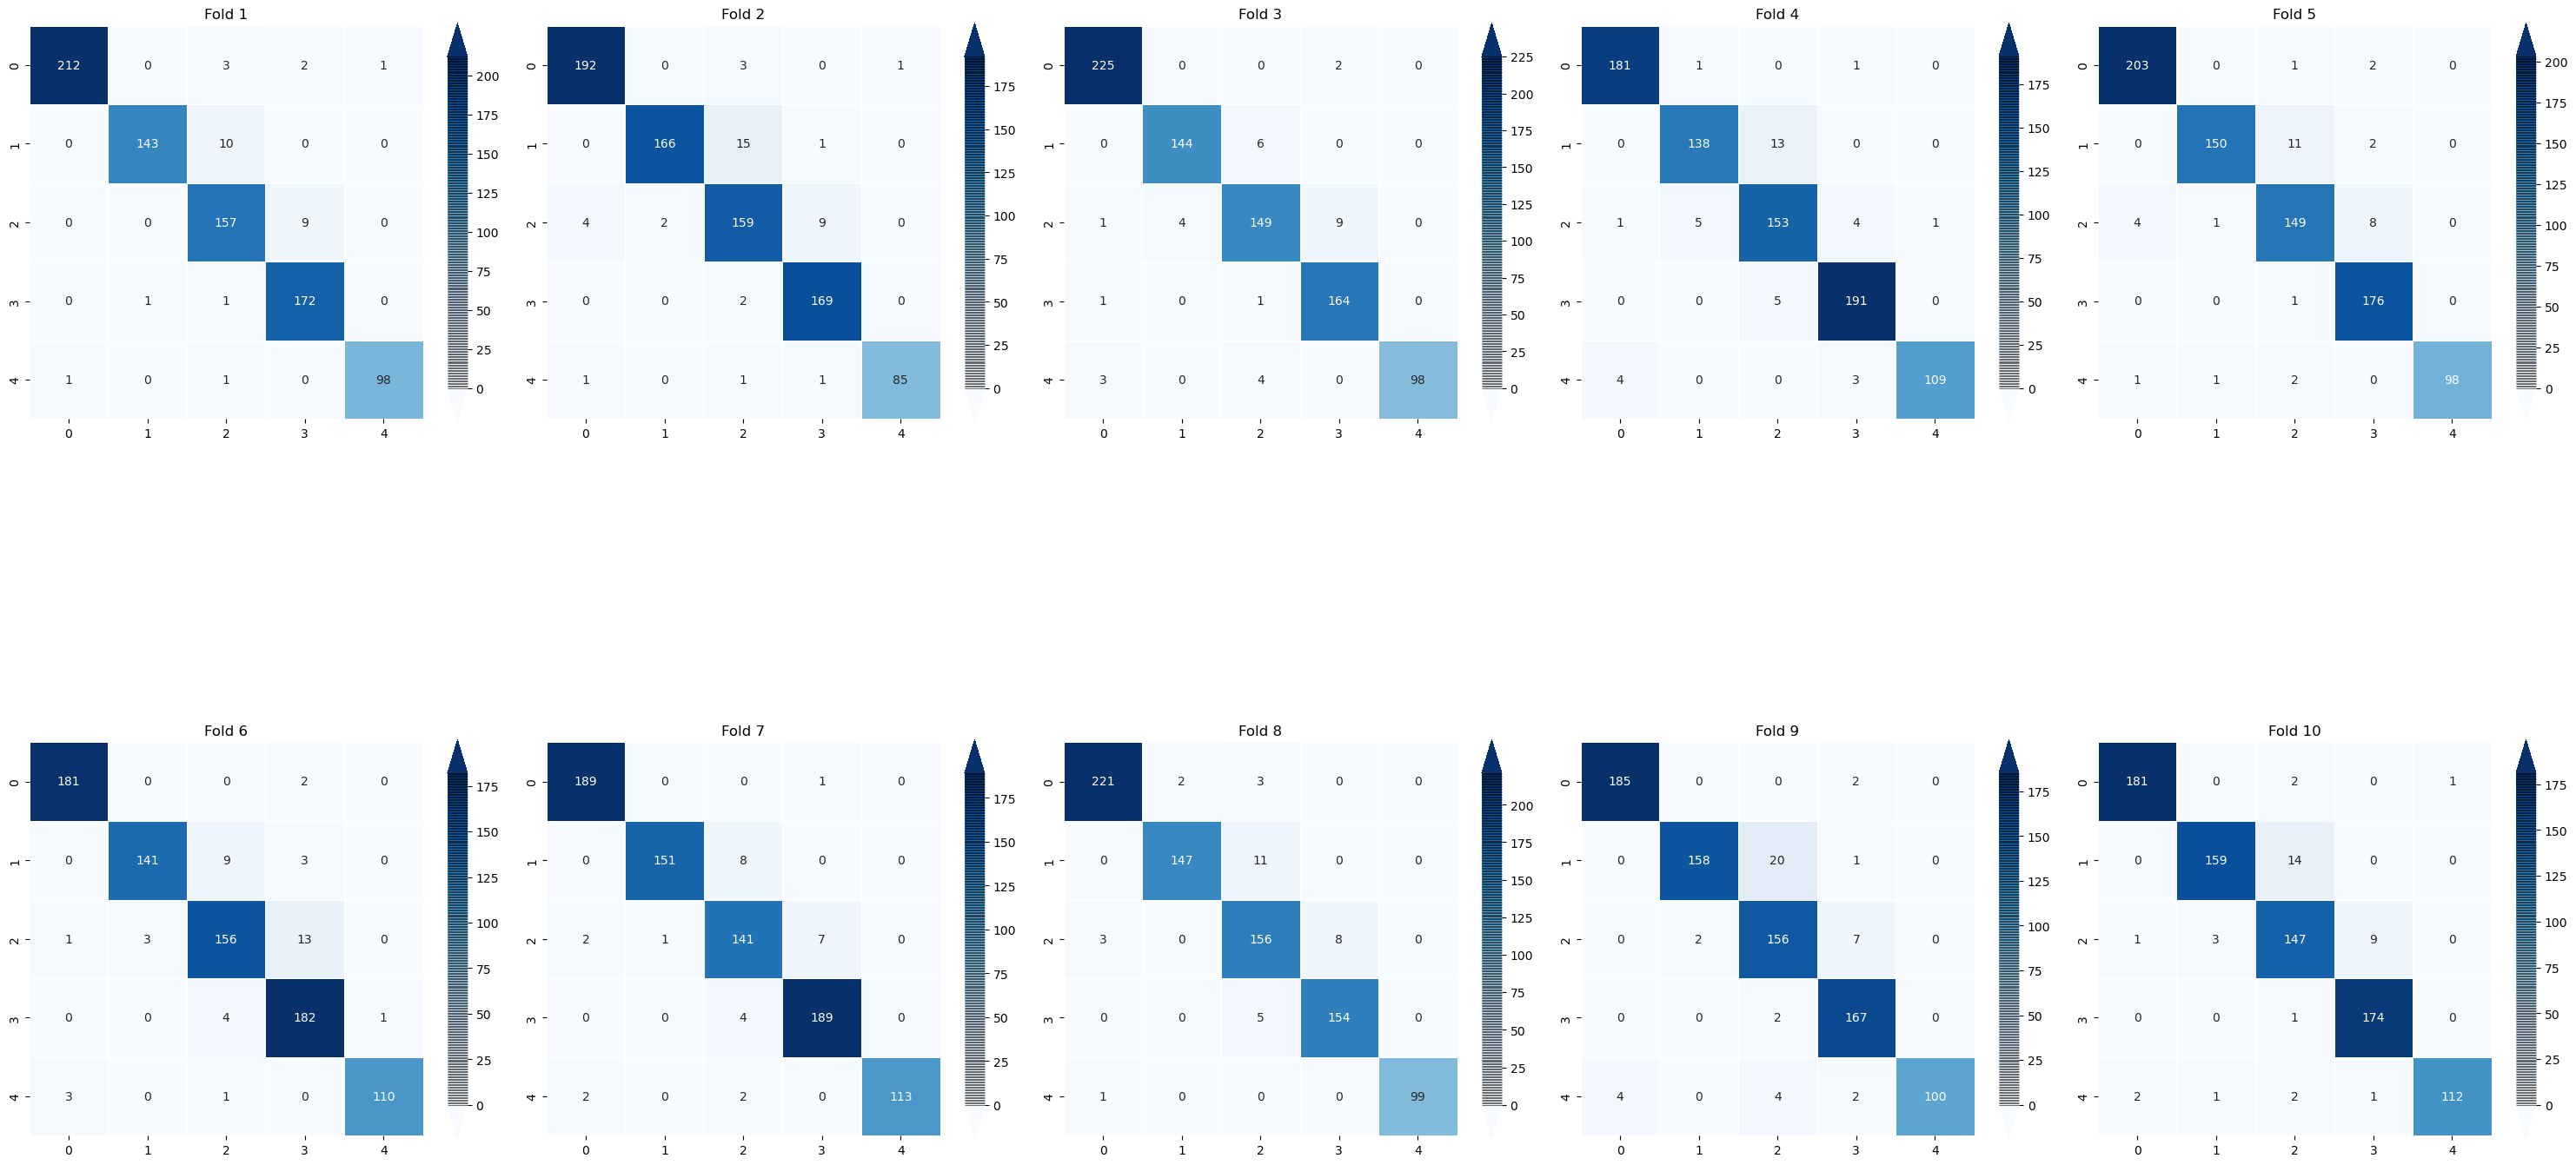

In [42]:
# Plot confusion matrix for each fold on a separate subplot
# fig, axes = plt.subplots(nrows=2, ncols=int(n_splits / 2), figsize=(12, 8))

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 20))


# Plot confusion matrix for each fold on a separate subplot
for i, ax in enumerate(axes.flat):
    cbar_kws = {
        "orientation": "vertical",
        "shrink": 0.4,
        "extend": "both",
        "extendfrac": 0.1,
        "drawedges": True,
    }

    sns.heatmap(
        confusion_matrices[i],
        annot=True,
        ax=ax,
        fmt="d",
        linewidth=0.5,
        square=True,
        cbar_kws=cbar_kws,
        cmap="Blues",
    )
    ax.set_title(f"Fold {i+1}")

plt.tight_layout()
plt.show()

#### Final Specificity, TPR, TNR, FPR, FNR

In [43]:
# Get the number of classes
n_classes = cm.shape[0]

# Initialize an empty list to store the specificity values
specificity = []

# Loop over each class
for i in range(n_classes):
  # Calculate the true negatives and false positives for class i
    tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i])
    fp = np.sum(cm[:, i]) - cm[i, i]

  # Calculate the specificity for class i
    spec = tn / (tn + fp)

  # Append the specificity to the list
    specificity.append(spec)

# Print the specificity values
print("Specificity for each class:")
for i in range(n_classes):
    print(f"Class {i}: {specificity[i]:.2f}")

Specificity for each class:
Class 0: 0.99
Class 1: 0.99
Class 2: 0.97
Class 3: 0.98
Class 4: 1.00


In [44]:
# Import numpy library
import numpy as np

# Calculate the false positives, false negatives, true positives, and true negatives for each class
fp = np.sum(cm, axis=0) - np.diag(cm)
fn = np.sum(cm, axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = np.sum(cm) - (fp + fn + tp)

# Calculate the false positive rate, false negative rate, true positive rate, and true negative rate for each class
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

# Print the FPR, FNR, TPR, and TNR values for each class
print("FPR for each class:")
for i in range(n_classes):
    print(f"Class {i}: {fpr[i]:.2f}")

print("FNR for each class:")
for i in range(n_classes):
    print(f"Class {i}: {fnr[i]:.2f}")

print("TPR for each class:")
for i in range(n_classes):
    print(f"Class {i}: {tpr[i]:.2f}")

print("TNR for each class:")
for i in range(n_classes):
    print(f"Class {i}: {tnr[i]:.2f}")

FPR for each class:
Class 0: 0.01
Class 1: 0.00
Class 2: 0.03
Class 3: 0.02
Class 4: 0.00
FNR for each class:
Class 0: 0.01
Class 1: 0.08
Class 2: 0.07
Class 3: 0.02
Class 4: 0.04
TPR for each class:
Class 0: 0.98
Class 1: 0.92
Class 2: 0.93
Class 3: 0.98
Class 4: 0.96
TNR for each class:
Class 0: 0.99
Class 1: 1.00
Class 2: 0.97
Class 3: 0.98
Class 4: 1.00
